<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving aaron-burden-GVnUVP8cs1o-unsplash.jpg to aaron-burden-GVnUVP8cs1o-unsplash (5).jpg

Upload Style Image


Saving bryan-colosky-3ChXTytXDUI-unsplash.jpg to bryan-colosky-3ChXTytXDUI-unsplash (1).jpg
Content Path: <_io.BytesIO object at 0x7f67803c5ba0>
Style Path: <_io.BytesIO object at 0x7f66c1dd7ca8>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


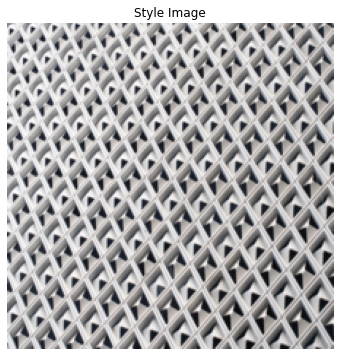

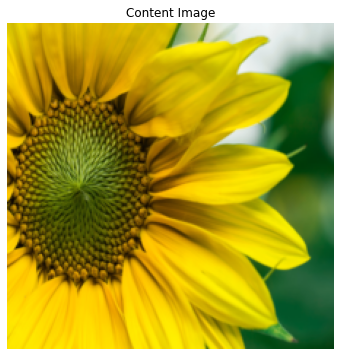

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    fig,ax = plt.subplots(figsize=(6,6))
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    fig.show()

display(style_image, title='Style Image')
display(content_image, title='Content Image')

___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
    # Choose the layer indeces to use for style and content transfer
vgg_style_layers = ["conv2_1", "conv4_2", "conv3_1", "conv4_1", "conv5_1"]
vgg_content_layers = ["conv2_1"]
def get_index_list(list_names):
    list_index = list()
    for name in list_names:
        list_index.append(vgg_names.index(name))
    return list_index
 
vgg_style_index = get_index_list(vgg_style_layers)
vgg_content_index = get_index_list(vgg_content_layers)
# Create the vgg network in eval mode 
#  with our forward method that returns the outputs of the intermediate layers we requested
vgg_style_network = VGGIntermediate(vgg_style_index).cuda()
vgg_content_network = VGGIntermediate(vgg_content_index).cuda()
# Cache the outputs of the content and style layers for their respective images
outputs_content = vgg_content_network(content_image)
outputs_style = vgg_style_network(style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [ ]:
def gram_matrix(input):
    batch, c, h, w = input.size()
    #compute the gram matrix
    features = input.view(batch*c,h*w)
    G = torch.mm(features, features.t())
    #normalize gram matrix values by the sizes
    return G.div(batch*c*h*w)

def get_loss_list(loss, list_layers):
    #intialize dictionary
    dict_save = dict()
    #construct new dictionary
    for keys,values in list_layers.items():
        dict_save[keys] = loss(values)
    return dict_save

class ContentLoss(nn.Module):
    def __init__(self,original):
        super(ContentLoss,self).__init__()
        self.target = nn.Parameter(original)

    def forward(self,input):
        #here the input is the generated image
        #calculate mean squared error loss
        return F.mse_loss(input,self.target)

        
class StyleLoss(nn.Module):
    def __init__(self,original,wl=1/5):
        super(StyleLoss,self).__init__()
        self.target=nn.Parameter(gram_matrix(original))
        self.wl = 1/5

    def forward(self,input):
        #compute the gram matrix
        gram = gram_matrix(input)
        #the normalization coefficient is the gram matrix computation
        return F.mse_loss(gram,self.target)

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_loss_dict = get_loss_list(ContentLoss, outputs_content)
# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_loss_dict = get_loss_list(StyleLoss, outputs_style)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



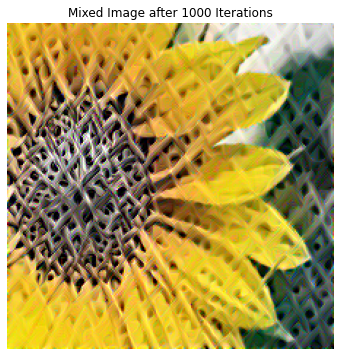

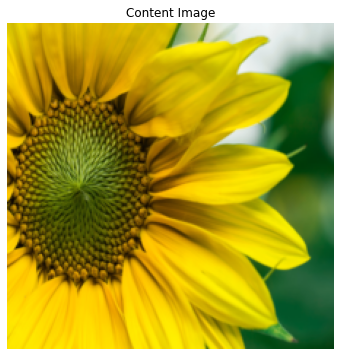

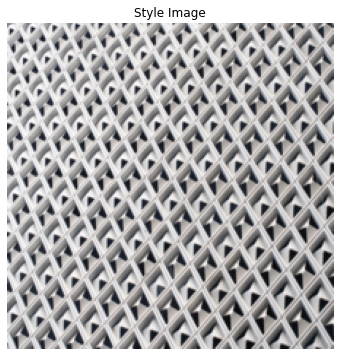

In [ ]:
# Start with a copy of the content image
generated_image = torch.clone(content_image).cuda()
generated_image.requires_grad = True
# Run the optimizer on the images to change the image
optimizer = optim.Adam([generated_image], lr=0.01)
alpha = 1
beta = 1000
#  using the loss of the style and content layers
#  to backpropagate errors 
num_steps = 1000
losses = []
loop = tqdm(total=num_steps, position=0, leave=False) 
for step in range(num_steps):
    #reset the optimizer gradient
    optimizer.zero_grad()  
    #get the network outputs
    y_hat_content = vgg_content_network(generated_image) 
    y_hat_style = vgg_style_network(generated_image)
    #compute the style loss
    style_loss = torch.Tensor([0.0]).cuda()
    for key,value in style_loss_dict.items():
        style_loss += value.wl*value(y_hat_style[key])

    #compute the content loss
    content_loss = torch.Tensor([0.0]).cuda()
    for key,value in content_loss_dict.items():
        content_loss += value(y_hat_content[key])

    #compute the total loss
    loss = alpha*content_loss+beta*style_loss
    #take a step with the optimizer
    loss.backward()
    optimizer.step()
    #clamp the image
    generated_image.data.clamp_(0,1)
    if (step % 50 == 0):
        #show the style and content loss
        losses.append(loss.item())
        loop.set_description('step:{}, content loss:{:.4f}, style loss:{:.4f}, total loss:{:.4f}'
                             .format(step,content_loss.item(),style_loss.item(),loss.item()))

    loop.update(1)


loop.close()
# Show the image
display(generated_image,title="Mixed Image after {} Iterations".format(num_steps))
display(content_image, title="Content Image")
display(style_image, title="Style Image")

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

(1) Equation (1) in the paper, is the computation for the context loss on specified layer. It is computing the squared error loss between the original image (p) activation values (P) and the new generated image (x) activation function (F). At the beginning, this will be zero because they are the same, but as it gets closer to the style image this loss will not be zero. l is the layer and ij are the row column indeces. p, x and the original image and the generated image.

(2) Equation (3) in the paper is the the Gram matrix of the F matrix discussed in the explanation for equation 1. l is again the layer, and G at index ij is the inner product between the feature map F_{i,:} and F_{:,j} (indexed according to python indexing).

(3) Equation (4) Is the contribution of of a layer of the syle matrices to the total style loss. This is computed by finding the feature dimensions (M_l) and total number of features (N_l) as well as the Gram matrix of the input activation layer (G_l) and the gram matrix of the layer of the original matrix (A_l). 

(4) Equation (5) is the summed total loss of all the style layers. We sum over the total number (L) and each has weights (w_l) and a contribution to total loss (E_l) given by equation (4)